In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
import cv2
from tqdm import tqdm

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [4]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
dataset = datasets.CIFAR10(root='data/', download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='data/',download=True, train=False, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomCrop(size=(32, 32), padding=4)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [6]:
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
class_count = {}
for _, index in dataset:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
class_count

{'frog': 5000,
 'truck': 5000,
 'deer': 5000,
 'automobile': 5000,
 'bird': 5000,
 'horse': 5000,
 'ship': 5000,
 'cat': 5000,
 'dog': 5000,
 'airplane': 5000}

In [ ]:
for option in dir(dataset):
    if option[0] != '_':
        print(option)

base_folder
class_to_idx
classes
data
download
extra_repr
filename
meta
root
target_transform
targets
test_list
tgz_md5
train
train_list
transform
transforms
url


In [ ]:
print(dataset.data.shape)
# print(dataset.targets)
print(test_dataset.data.shape)
# print(test_dataset.targets.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [7]:
torch.manual_seed(43)
val_size = 5000
train_size = len(dataset) - val_size

In [8]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [9]:
batch_size = 128

In [10]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size ,num_workers=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size = batch_size*2, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size*2, num_workers=4,shuffle=True , pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
print(train_loader)

In [ ]:
for option in dir(train_loader):
    if option[0] != '_':
        print(option)

batch_sampler
batch_size
check_worker_number_rationality
collate_fn
dataset
drop_last
generator
multiprocessing_context
num_workers
persistent_workers
pin_memory
pin_memory_device
prefetch_factor
sampler
timeout
worker_init_fn


images.shape: torch.Size([128, 3, 32, 32])


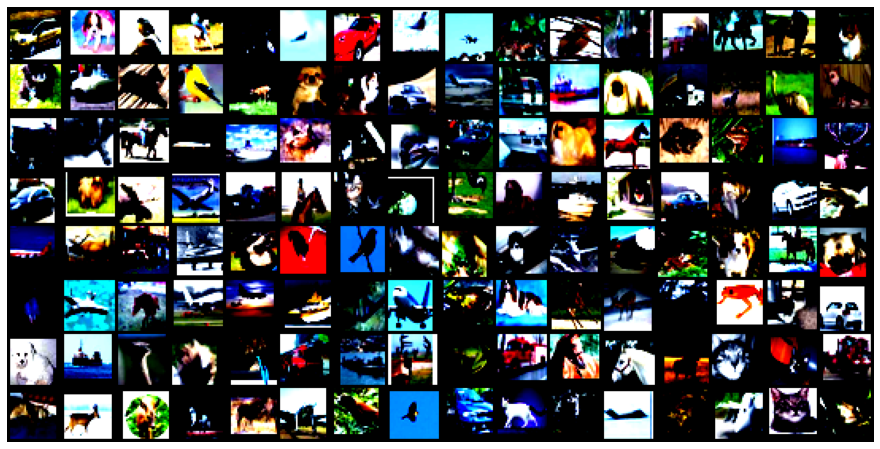

In [ ]:
from torchvision.utils import make_grid
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [11]:
input_size = 3*32*32
output_size = 10
hidden_size = [256,128]

In [ ]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_size, hidden_size[0]),
    nn.ReLU(),
    nn.Linear(hidden_size[0],hidden_size[1]),
    nn.ReLU(),
    nn.Linear(hidden_size[1],output_size)
)

In [ ]:
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=10, bias=True)
)


In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [12]:
import torch.nn.functional as F

def training_step(model, batch):
        images, labels = batch[0].to(device), batch[1].to(device)  # load the batch to the available device (cpu/gpu)
        out = model(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

def validation_step(model, batch):
        images, labels = batch[0].to(device), batch[1].to(device)  # load the batch to the available device (cpu/gpu)
        out = model(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

def validation_epoch_end(outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

def epoch_end(epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [13]:
def evaluate(model, val_loader):
    outputs = [validation_step(model,batch) for batch in val_loader]
    return validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr,weight_decay=0.0005)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = training_step(model,batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
lrs = [1e-1,1e-2,1e-3,1e-4]

In [ ]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.310457229614258, 'val_acc': 0.11120174080133438}]

In [ ]:
from datetime import datetime
for lr in lrs:

    print(f"______________________({datetime.now()})_______________________________")
    history += fit(10, lr, model, train_loader, val_loader)
    print(f"______________________ ({datetime.now()})_______________________________")


______________________(2022-12-21 16:21:17.213201)_______________________________
Epoch [0], val_loss: 1.8400, val_acc: 0.3387
Epoch [1], val_loss: 1.6752, val_acc: 0.4069
Epoch [2], val_loss: 1.6734, val_acc: 0.4112
Epoch [3], val_loss: 1.6063, val_acc: 0.4304
Epoch [4], val_loss: 1.5600, val_acc: 0.4369
Epoch [5], val_loss: 1.6124, val_acc: 0.4301
Epoch [6], val_loss: 1.5374, val_acc: 0.4510
Epoch [7], val_loss: 1.5190, val_acc: 0.4621
Epoch [8], val_loss: 1.4909, val_acc: 0.4609
Epoch [9], val_loss: 1.4796, val_acc: 0.4680
______________________ (2022-12-21 16:24:01.070258)_______________________________
______________________(2022-12-21 16:24:01.070311)_______________________________
Epoch [0], val_loss: 1.4020, val_acc: 0.4952
Epoch [1], val_loss: 1.3881, val_acc: 0.5101
Epoch [2], val_loss: 1.3731, val_acc: 0.5065
Epoch [3], val_loss: 1.3734, val_acc: 0.5084
Epoch [4], val_loss: 1.3668, val_acc: 0.5078
Epoch [5], val_loss: 1.3809, val_acc: 0.5121
Epoch [6], val_loss: 1.3633, val_

In [14]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [15]:

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

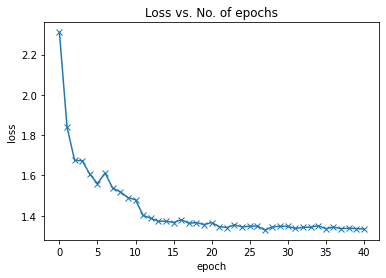

In [ ]:
plot_losses(history)


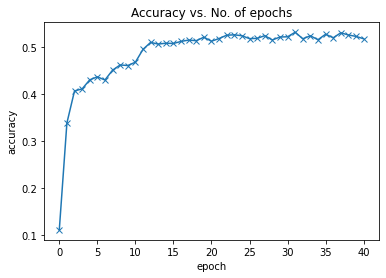

In [ ]:
plot_accuracies(history)


In [ ]:
evaluate(model, test_loader)


{'val_loss': 1.371119737625122, 'val_acc': 0.512988269329071}

In [ ]:
model_cnn = nn.Sequential(            
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            # nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            # nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            # nn.BatchNorm2d(256),


            nn.Flatten(), 
            nn.Linear(256*4*4, 10),
)

In [ ]:
history = fit(10,0.001,model_cnn,train_loader, val_loader,opt_func = torch.optim.Adam)

Epoch [0], val_loss: 1.4507, val_acc: 0.4509
Epoch [1], val_loss: 1.1150, val_acc: 0.6008
Epoch [2], val_loss: 0.9556, val_acc: 0.6606
Epoch [3], val_loss: 0.8190, val_acc: 0.7122
Epoch [4], val_loss: 0.8221, val_acc: 0.7154
Epoch [5], val_loss: 0.6893, val_acc: 0.7604
Epoch [6], val_loss: 0.7173, val_acc: 0.7432
Epoch [7], val_loss: 0.6743, val_acc: 0.7699
Epoch [8], val_loss: 0.6163, val_acc: 0.7932
Epoch [9], val_loss: 0.5939, val_acc: 0.7971


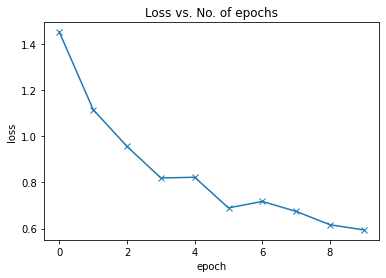

In [ ]:
plot_losses(history)


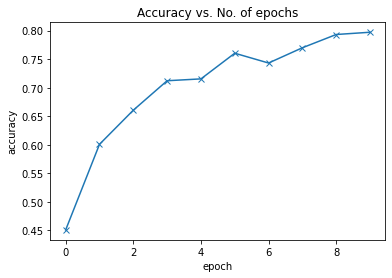

In [ ]:
plot_accuracies(history)


In [ ]:
evaluate(model_cnn, test_loader)


{'val_loss': 0.5673812627792358, 'val_acc': 0.8121093511581421}

In [16]:

from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score
import seaborn as sn
import pandas as pd

def predict_measurement(model,data_set,classes,name):
    
    y_pred = []
    y_true = []

    # iterate over test data
    for inputs, labels in data_set:
          output = model(inputs.to(device)) # Feed Network

          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output) # Save Prediction
          
          labels = labels.to(device).data.cpu().numpy()
          y_true.extend(labels) # Save Truth


    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                        columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig(name+'output.png')
    print("_____________________________________________________")
    #precision score each item
    list_of_precision_score = precision_score(y_true, y_pred, average=None)
    for index in range(len(classes)):
        print(classes[index]+" : "+str(list_of_precision_score[index]))
    print("_$_$_$_$_$_$_$_$_$_$_$_$_$_$_$_$_$__$_$_$_$_$_$_$_")
    #recall score each item
    list_of_recall_score = recall_score(y_true, y_pred, average=None)
    for index in range(len(classes)):
        print(classes[index]+" : "+str(list_of_recall_score[index]))
    # f1 score each item
    print("_$_$_$_$_$_$_$_$_$_$_$_$_$_$_$_$_$__$_$_$_$_$_$_$_")
    list_of_F1 = f1_score(y_true, y_pred,average=None) 
    for index in range(len(classes)):
        print(classes[index]+" : "+str(list_of_F1[index]))


    # precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred,average="micro")
    print("_____________________________________________________")
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred,average="micro")
    print("_____________________________________________________")
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred,average="micro")
    print("_____________________________________________________")
    print('F1 score: %f' % f1)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


_____________________________________________________
airplane : 0.7781818181818182
automobile : 0.838737949167397
bird : 0.7191448007774538
cat : 0.7763157894736842
deer : 0.7795121951219512
dog : 0.7758985200845666
frog : 0.8482490272373541
horse : 0.8097050428163654
ship : 0.9050104384133612
truck : 0.8516377649325626
_$_$_$_$_$_$_$_$_$_$_$_$_$_$_$_$_$__$_$_$_$_$_$_$_
airplane : 0.856
automobile : 0.957
bird : 0.74
cat : 0.531
deer : 0.799
dog : 0.734
frog : 0.872
horse : 0.851
ship : 0.867
truck : 0.884
_$_$_$_$_$_$_$_$_$_$_$_$_$_$_$_$_$__$_$_$_$_$_$_$_
airplane : 0.8152380952380952
automobile : 0.8939747781410554
bird : 0.7294233612617051
cat : 0.6306413301662708
deer : 0.7891358024691358
dog : 0.7543679342240494
frog : 0.8599605522682445
horse : 0.8298391028766455
ship : 0.8855975485188968
truck : 0.8675171736997055
_____________________________________________________
Precision: 0.809100
_____________________________________________________
Recall: 0.809100
_____________________

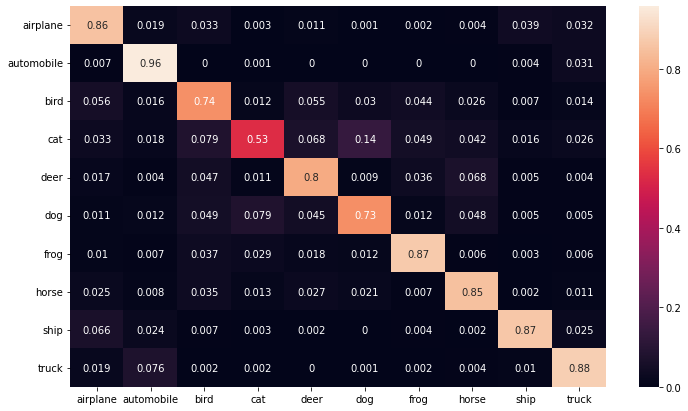

In [ ]:
predict_measurement(model_cnn,test_loader,classes,"CNN")

In [ ]:

model_cnn2 = nn.Sequential(            
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.Dropout(0.2), # 20% Probability
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.Dropout(0.2),  # 20% Probability
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.Dropout(0.2),  # 20% Probability
            nn.BatchNorm2d(256),


            nn.Flatten(), 
            nn.Linear(256*4*4, 10),
)

In [ ]:
history = fit(10,0.001,model_cnn2,train_loader, val_loader,opt_func = torch.optim.Adam)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], val_loss: 1.1081, val_acc: 0.6053
Epoch [1], val_loss: 0.8921, val_acc: 0.6877
Epoch [2], val_loss: 0.7679, val_acc: 0.7210
Epoch [3], val_loss: 0.6795, val_acc: 0.7657
Epoch [4], val_loss: 0.6652, val_acc: 0.7675
Epoch [5], val_loss: 0.6157, val_acc: 0.7882
Epoch [6], val_loss: 0.5815, val_acc: 0.8030
Epoch [7], val_loss: 0.6093, val_acc: 0.7957
Epoch [8], val_loss: 0.5609, val_acc: 0.8111
Epoch [9], val_loss: 0.5451, val_acc: 0.8225


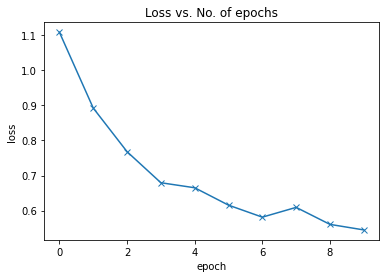

In [ ]:
plot_losses(history)


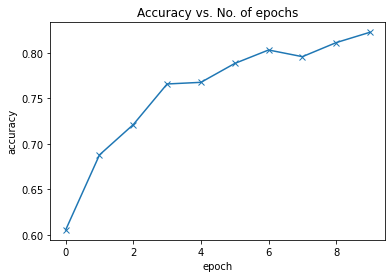

In [ ]:
plot_accuracies(history)


In [ ]:
evaluate(model_cnn2, test_loader)


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'val_loss': 0.5280101299285889, 'val_acc': 0.818066418170929}

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


_____________________________________________________
airplane : 0.7835888187556357
automobile : 0.9148296593186372
bird : 0.7447236180904523
cat : 0.7096774193548387
deer : 0.8449258836944128
dog : 0.8065610859728507
frog : 0.782871972318339
horse : 0.8528265107212476
ship : 0.8746298124383021
truck : 0.8774703557312253
_$_$_$_$_$_$_$_$_$_$_$_$_$_$_$_$_$__$_$_$_$_$_$_$_
airplane : 0.869
automobile : 0.913
bird : 0.741
cat : 0.66
deer : 0.741
dog : 0.713
frog : 0.905
horse : 0.875
ship : 0.886
truck : 0.888
_$_$_$_$_$_$_$_$_$_$_$_$_$_$_$_$_$__$_$_$_$_$_$_$_
airplane : 0.8240872451398766
automobile : 0.9139139139139139
bird : 0.7428571428571429
cat : 0.683937823834197
deer : 0.7895578050079914
dog : 0.7569002123142251
frog : 0.839517625231911
horse : 0.8637709772951628
ship : 0.8802781917536016
truck : 0.882703777335984
_____________________________________________________
Precision: 0.819100
_____________________________________________________
Recall: 0.819100
________________________

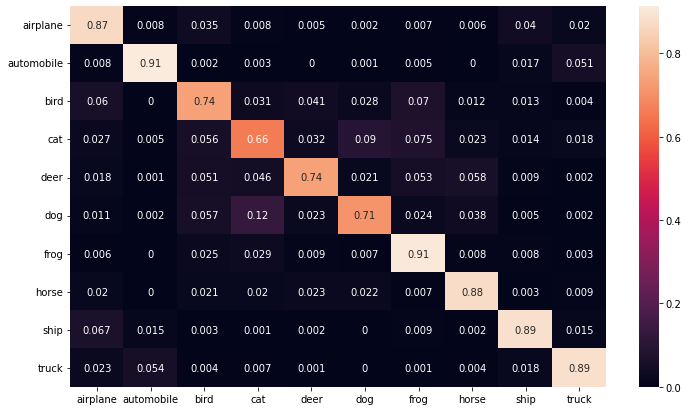

In [ ]:
predict_measurement(model_cnn2,test_loader,classes,"CNN2")

In [17]:
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
class Network(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.features = nn.Sequential(
            *list(pretrained_model.features.children())
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=128, out_features=10)
        )

    def forward(self, t):
        t = self.features(t)
        t = t.reshape(t.size(0), -1)
        t = self.classifier(t)

        return t

vgg16 = Network(vgg16)
vgg16

Network(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [19]:
# transfer learning (first 8 layers of vgg16)
# freeze the transferred weights which won't be trained
for layer_num, child in enumerate(vgg16.features.children()):
    if layer_num < 19:
        for param in child.parameters():
            param.requires_grad_(False)


In [20]:
from torch.utils.tensorboard import SummaryWriter


def train(model,train_set,valid_loader,num_epochs,optimizer):
    
    history = []
    comment = f'-transferlr_vgg16'  # will be used for naming the run    
    model.to(device)
    
    for epoch in range(num_epochs):
        ###################
        # train the model #
        ###################
        train_loop = tqdm(train_loader)
        model.train()  # set the model to train mode
        for batch in train_loop:
            
            loss = training_step(model, batch) # calculate loss
            optimizer.zero_grad()  # clear accumulated gradients from the previous pass
            loss.backward()  # backward pass
            optimizer.step()  # perform a single optimization step

        model.eval()  # set the model to evaluation mode
        with torch.no_grad():  # turn off grad tracking, as we don't need gradients for validation
            ######################
            # validate the model #
            ######################
            result = evaluate(model, val_loader)
            epoch_end(epoch, result)
            history.append(result)
        
        torch.save(model.state_dict(), f'transferlr_vgg16.pth')


    return history    
  


In [21]:
optimizer = optim.SGD(
    [      # parameters which need optimization
        {'params':vgg16.features[19:].parameters(), 'lr':0.001},
        {'params':vgg16.classifier.parameters()}
    ], lr=0.01, momentum=0.9, weight_decay=1e-3)

history = train(vgg16,train_loader,val_loader,30,optimizer)

  0%|          | 0/352 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 352/352 [00:17<00:00, 19.79it/s]


Epoch [0], val_loss: 0.8175, val_acc: 0.7117


100%|██████████| 352/352 [00:17<00:00, 20.05it/s]


Epoch [1], val_loss: 0.7254, val_acc: 0.7486


100%|██████████| 352/352 [00:17<00:00, 19.77it/s]


Epoch [2], val_loss: 0.6750, val_acc: 0.7588


100%|██████████| 352/352 [00:16<00:00, 21.49it/s]


Epoch [3], val_loss: 0.6103, val_acc: 0.7818


100%|██████████| 352/352 [00:16<00:00, 21.42it/s]


Epoch [4], val_loss: 0.5960, val_acc: 0.7929


100%|██████████| 352/352 [00:16<00:00, 21.26it/s]


Epoch [5], val_loss: 0.6012, val_acc: 0.7933


100%|██████████| 352/352 [00:16<00:00, 21.39it/s]


Epoch [6], val_loss: 0.5920, val_acc: 0.7950


100%|██████████| 352/352 [00:16<00:00, 21.45it/s]


Epoch [7], val_loss: 0.5444, val_acc: 0.8065


100%|██████████| 352/352 [00:16<00:00, 21.29it/s]


Epoch [8], val_loss: 0.5556, val_acc: 0.8031


100%|██████████| 352/352 [00:16<00:00, 21.18it/s]


Epoch [9], val_loss: 0.5399, val_acc: 0.8149


100%|██████████| 352/352 [00:16<00:00, 21.14it/s]


Epoch [10], val_loss: 0.5360, val_acc: 0.8185


100%|██████████| 352/352 [00:16<00:00, 21.51it/s]


Epoch [11], val_loss: 0.5151, val_acc: 0.8237


100%|██████████| 352/352 [00:17<00:00, 20.10it/s]


Epoch [12], val_loss: 0.5002, val_acc: 0.8276


100%|██████████| 352/352 [00:16<00:00, 21.58it/s]


Epoch [13], val_loss: 0.4932, val_acc: 0.8337


100%|██████████| 352/352 [00:16<00:00, 21.10it/s]


Epoch [14], val_loss: 0.5396, val_acc: 0.8210


100%|██████████| 352/352 [00:16<00:00, 21.28it/s]


Epoch [15], val_loss: 0.4809, val_acc: 0.8362


100%|██████████| 352/352 [00:16<00:00, 21.64it/s]


Epoch [16], val_loss: 0.4631, val_acc: 0.8381


100%|██████████| 352/352 [00:16<00:00, 21.58it/s]


Epoch [17], val_loss: 0.4982, val_acc: 0.8354


100%|██████████| 352/352 [00:16<00:00, 21.64it/s]


Epoch [18], val_loss: 0.4694, val_acc: 0.8432


100%|██████████| 352/352 [00:16<00:00, 21.68it/s]


Epoch [19], val_loss: 0.5061, val_acc: 0.8241


100%|██████████| 352/352 [00:16<00:00, 21.57it/s]


Epoch [20], val_loss: 0.4880, val_acc: 0.8385


100%|██████████| 352/352 [00:17<00:00, 19.91it/s]


Epoch [21], val_loss: 0.4881, val_acc: 0.8387


100%|██████████| 352/352 [00:16<00:00, 21.25it/s]


Epoch [22], val_loss: 0.4680, val_acc: 0.8416


100%|██████████| 352/352 [00:16<00:00, 21.49it/s]


Epoch [23], val_loss: 0.4655, val_acc: 0.8448


100%|██████████| 352/352 [00:16<00:00, 21.53it/s]


Epoch [24], val_loss: 0.4735, val_acc: 0.8445


100%|██████████| 352/352 [00:16<00:00, 21.60it/s]


Epoch [25], val_loss: 0.4660, val_acc: 0.8438


100%|██████████| 352/352 [00:16<00:00, 21.60it/s]


Epoch [26], val_loss: 0.4888, val_acc: 0.8381


100%|██████████| 352/352 [00:16<00:00, 21.06it/s]


Epoch [27], val_loss: 0.4817, val_acc: 0.8416


100%|██████████| 352/352 [00:16<00:00, 21.52it/s]


Epoch [28], val_loss: 0.4759, val_acc: 0.8452


100%|██████████| 352/352 [00:16<00:00, 21.63it/s]


Epoch [29], val_loss: 0.4819, val_acc: 0.8428


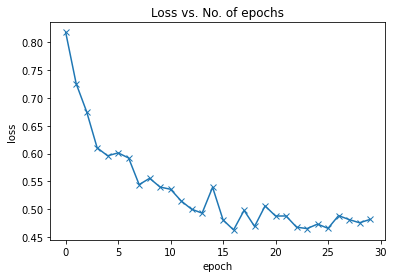

In [22]:
plot_losses(history)


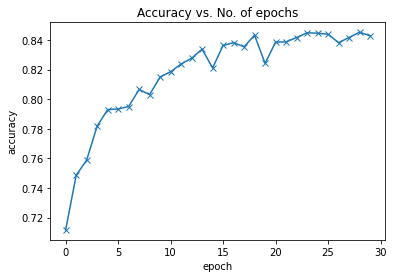

In [23]:
plot_accuracies(history)


In [24]:
evaluate(vgg16, test_loader)


{'val_loss': 0.44929057359695435, 'val_acc': 0.8534179925918579}

_____________________________________________________
airplane : 0.9251396648044693
automobile : 0.93
bird : 0.8326612903225806
cat : 0.7001862197392924
deer : 0.8058991436726927
dog : 0.781985670419652
frog : 0.8704761904761905
horse : 0.9150537634408602
ship : 0.9224652087475149
truck : 0.8965853658536586
_$_$_$_$_$_$_$_$_$_$_$_$_$_$_$_$_$__$_$_$_$_$_$_$_
airplane : 0.828
automobile : 0.93
bird : 0.826
cat : 0.752
deer : 0.847
dog : 0.764
frog : 0.914
horse : 0.851
ship : 0.928
truck : 0.919
_$_$_$_$_$_$_$_$_$_$_$_$_$_$_$_$_$__$_$_$_$_$_$_$_
airplane : 0.8738786279683377
automobile : 0.93
bird : 0.8293172690763052
cat : 0.7251687560270011
deer : 0.825938566552901
dog : 0.7728882144663631
frog : 0.8917073170731707
horse : 0.8818652849740932
ship : 0.9252243270189431
truck : 0.9076543209876544
_____________________________________________________
Precision: 0.855900
_____________________________________________________
Recall: 0.855900
__________________________________________________

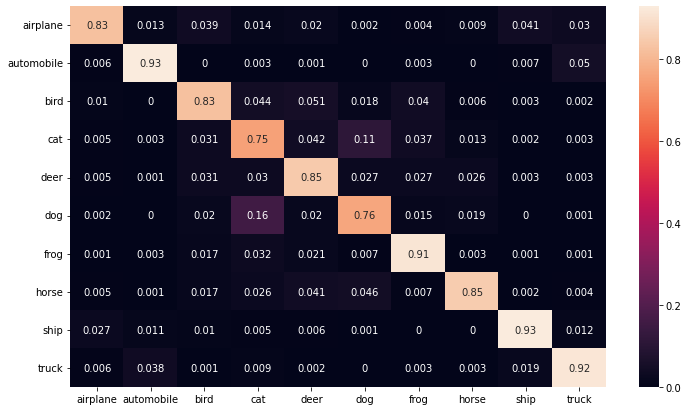

In [25]:
predict_measurement(vgg16,test_loader,classes,"vgg16")

In [ ]:
torch.save(model.state_dict(), "model_MLP")

In [ ]:
torch.save(model_cnn.state_dict(), "model_CNN")

In [ ]:
torch.save(model_cnn2.state_dict(), "model_CNN2")